In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from abc import abstractmethod
import numpy as np
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')
from pl_bolts.callbacks import PrintTableMetricsCallback

# import partial
from functools import partial
import pytorch_lightning as pl
from torch.optim import Adam
from pytorch_lightning import Trainer

import os
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule
import torchvision

import matplotlib.pyplot as plt 

%matplotlib inline

/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/pl_bolts/utils/warnings.py:30: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  stdout_func(


# Defining Data Module

In [2]:
from torch.utils.data import Dataset

class MNISTWithLabelsDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.num_classes = 10

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        label_tensor = torch.tensor(label, dtype=torch.int64)
        # print(label_tensor.shape)
        # print(image.shape)
        # onehot encoding the label
        one_hot_label = F.one_hot(label_tensor, num_classes=self.num_classes).float()
        
        return (image, one_hot_label), label
        # return image, label



class MNISTDataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./data", batch_size: int = 256, num_workers: int = 4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            
        ])

    def setup(self, stage=None):
        mnist_train = MNIST(self.data_dir, train=True, download=True, transform=self.transform)
        mnist_val = MNIST(self.data_dir, train=False, download=True, transform=self.transform)
        self.mnist_train = MNISTWithLabelsDataset(mnist_train)
        self.mnist_val = MNISTWithLabelsDataset(mnist_val)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)


# mnist_data = MNISTDataModule()

# mnist_data.setup()

# x, y = mnist_data.train_dataloader().dataset[0]

# print(x[0][0])

# Defining Base Model

In [3]:
class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass




# Defining VAE Model

In [4]:
# nn class for printing input shape 
class myprint_pre(nn.Module):
    def __init__(self):
        super(myprint_pre, self).__init__()
    def forward(self, x, text = ''):
        # print("\nShape pre-print is: ", x.shape, end='\t')
        return x

class myprint_post(nn.Module):
    def __init__(self):
        super(myprint_post, self).__init__()
    def forward(self, x, text = ''):
        # print("Shape post-print is: ", x.shape, end='')
        return x


class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.pre_print = myprint_pre()
        self.post_print = myprint_post()

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
        self.hd = hidden_dims.copy()

        # Build Encoder
        for h_dim in hidden_dims:
            # cprint = partial(self.print, text = h_dim)
            modules.append(
                nn.Sequential(
                    self.pre_print,
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    self.post_print
                    # cprint
                )

            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 2, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 2, latent_dim)

        self.one_hot_encoded_dense = nn.Linear(10, self.hd[-1])

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    self.pre_print,
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                    self.post_print
                )
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        # print("Input to encoder is: ", input[0].shape, input[1].shape)
        result = self.encoder(input[0])

        encoded_dense = self.one_hot_encoded_dense(input[1])
        # print("\nResult of encoder is: ", result.shape)
        result = torch.flatten(result, start_dim=1)
        # print("Result of encoder flattened is: ", result.shape)

        #concatenate the one hot encoded dense layer with the flattened result
        result = torch.cat((result, encoded_dense), dim=1)

        # print("Result of encoder concatenated is: ", result.shape)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        # print("\nInput to decoder is: ", z.shape)
        result = self.decoder_input(z)
        # print("Result of decoder input is: ", result.shape)
        result = result.view(-1, self.hd[-1], 1, 1)
        # print("Result of decoder input reshaped is: ", result.shape)
        result = self.decoder(result)
        # print("Result of decoder is: ", result.shape)
        result = self.final_layer(result)
        # print("Result of final layer is: ", result.shape)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        # print("\nInput shape in forward: ", len(input), input[0].shape, input[1].shape)
        mu, log_var = self.encode(input)
        # print("Shape of mu in forward: ", mu.shape)
        # print("Shape of log_var in forward: ", log_var.shape)
        z = self.reparameterize(mu, log_var)
        # print("Shape of z (post reparameterize) in forward: ", z.shape)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset

        # print("\nShape of recons: ", recons.shape)
        # print("Shape of input: ", input.shape)

        recons_loss =F.mse_loss(recons, input[0])


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

# Pytorch Lightning Module

In [5]:
class VAEModel(pl.LightningModule):
    def __init__(self, vae, lr: float = 1e-3):
        super().__init__()
        self.vae = vae
        self.lr = lr

    def forward(self, x):
        return self.vae(x)

    def encode(self, x):
        return self.vae.encode(x)
    
    def decode(self, x):
        return self.vae.decode(x)
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        results = self.vae(x)
        # print("X is: ", len(x), x[0].shape, x[1].shape)
        # print("Results from vae: ", len(results), results[0].shape, results[1].shape)
        loss_dict = self.vae.loss_function(*results, M_N=x[0].shape[0])
        loss = loss_dict['loss']
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        results = self.vae(x)
        # print("X is: ", len(x), x[0].shape, x[1].shape)
        loss_dict = self.vae.loss_function(*results, M_N=x[0].shape[0])
        loss = loss_dict['loss']
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    def generate(self, x):
        return self.vae.generate(x)
    
    def sample(self, num_samples, current_device):
        return self.vae.sample(num_samples, current_device)


# Starting Training

In [6]:
callback = PrintTableMetricsCallback()


In [13]:
from pytorch_lightning import Trainer

# Set up the MNIST DataModule
mnist_datamodule = MNISTDataModule()

# Initialize the VAE
in_channels = 1
latent_dim = 512 
vae = VanillaVAE(in_channels=in_channels, latent_dim=latent_dim)

# Initialize the Lightning Module for the VAE
vae_model = VAEModel(vae)
trainer = Trainer(max_epochs=100, gpus=torch.cuda.device_count())
trainer.fit(vae_model, datamodule=mnist_datamodule)

# Save the trained VAE model
torch.save(vae_model.state_dict(), "vae_mnist.pth")



/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | vae  | VanillaVAE | 4.5 M 
------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.863    Total estimated model params size (MB)


Epoch 99: 100%|██████████| 275/275 [00:06<00:00, 41.81it/s, loss=0.594, v_num=25, train_loss_step=0.555, val_loss_step=0.680, val_loss_epoch=0.608, train_loss_epoch=0.601]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 275/275 [00:06<00:00, 40.67it/s, loss=0.594, v_num=25, train_loss_step=0.555, val_loss_step=0.680, val_loss_epoch=0.608, train_loss_epoch=0.601]


# Sampling

In [14]:
mnist_datamodule.mnist_val[4][0][0].unsqueeze(0).shape

torch.Size([1, 1, 32, 32])

In [15]:
mnist_datamodule.mnist_val[4][0][1].unsqueeze(0).shape

torch.Size([1, 10])

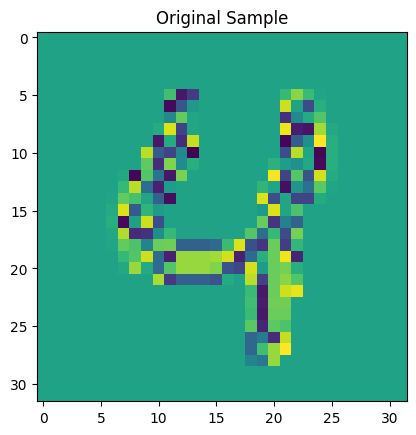

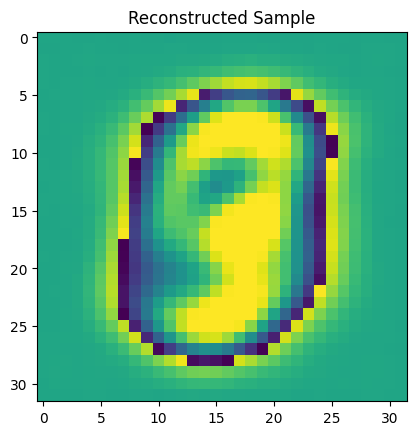

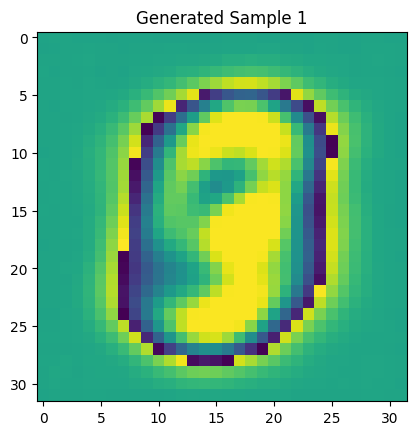

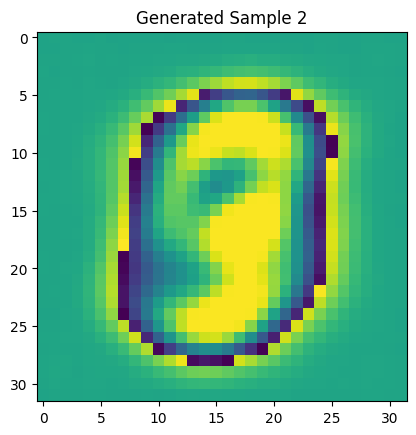

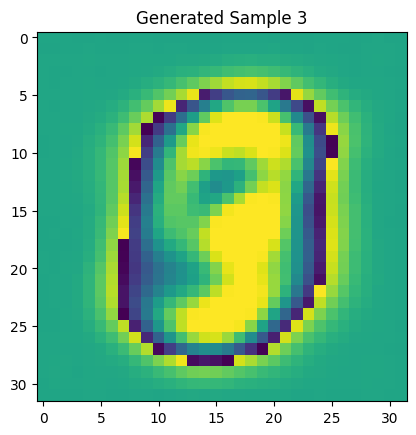

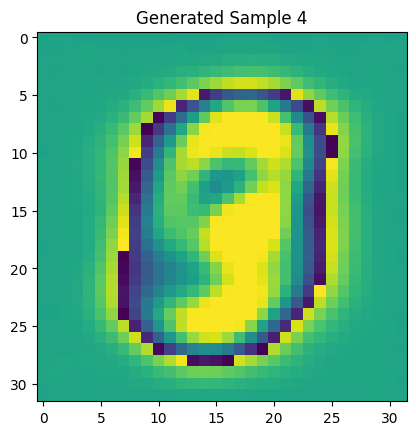

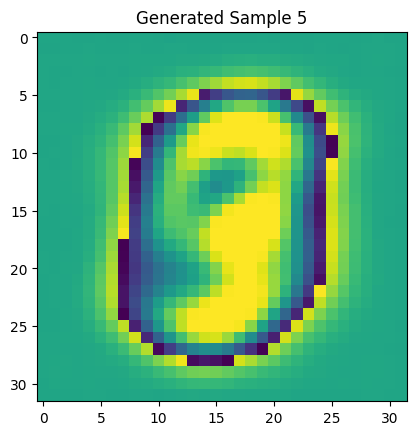

In [16]:
def imshow(tensor, title=None):
    tensor = tensor.detach().cpu()
    img = torchvision.transforms.ToPILImage()(tensor)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated
    
vae_model.eval()

# Load a sample from the MNIST dataset
id = 4
mnist_sample = (mnist_datamodule.mnist_val[4][0][0].unsqueeze(0), mnist_datamodule.mnist_val[4][0][1].unsqueeze(0))

# Reconstruct the sample using the VAE model
reconstructed_sample = vae_model.generate(mnist_sample)

# Display the original and reconstructed samples
plt.figure()
imshow(mnist_sample[0][0], title="Original Sample")
plt.figure()
imshow(reconstructed_sample[0], title="Reconstructed Sample")

# Generate new images from the VAE model
num_samples = 5
generated_samples = vae_model.sample(num_samples=num_samples, current_device=vae_model.device)

# Display the generated samples
for i in range(num_samples):
    plt.figure()
    imshow(generated_samples[i], title=f"Generated Sample {i + 1}")

# Plotting Distribution

/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


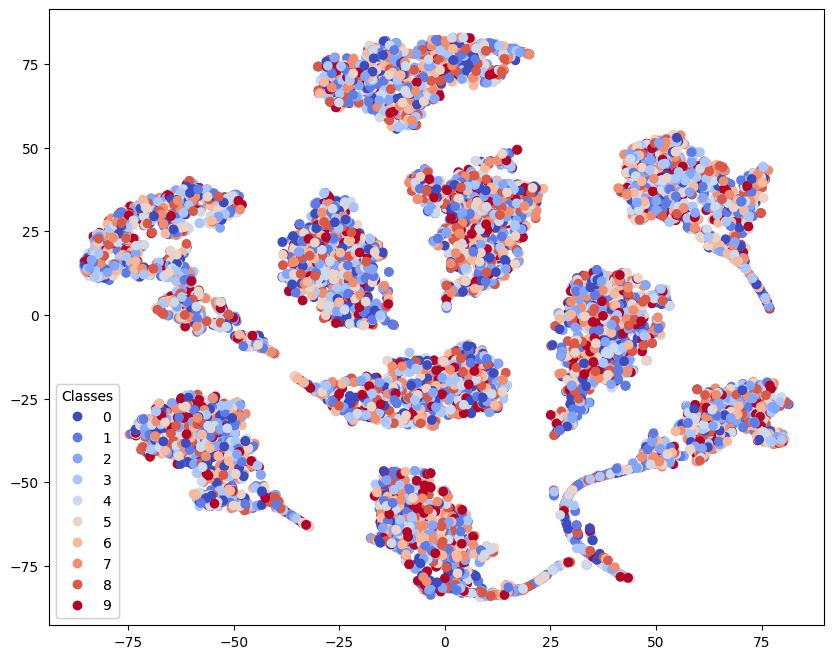

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming the VAE model is already loaded as `vae_model`
# and the data module is already created as `mnist_data`

# Prepare the validation data loader
val_loader = mnist_datamodule.val_dataloader()

# Initialize empty lists to store the mu values for each class
mu_values = [[] for _ in range(10)]
labels_list = []

# Iterate through the validation dataset
for (images, one_hot_labels), labels in val_loader:
    # Encode the images to obtain mu
    mu, _ = vae_model.encode((images, one_hot_labels))

    # Store the mu values for each class
    for i in range(len(labels)):
        label = labels[i].item()
        mu_values[label].append(mu[i].detach().numpy())
        labels_list.append(label)


# Convert lists to numpy arrays
mu_values = np.concatenate(mu_values, axis=0)
labels_list = np.array(labels_list)

# Reduce the dimensionality of the mu values to 2D
tsne = TSNE(n_components=2)
mu_values_2d = tsne.fit_transform(mu_values)

# Create a scatter plot with the 2D mu values, colored by class labels
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(mu_values_2d[:, 0], mu_values_2d[:, 1], c=labels_list, cmap="coolwarm")
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()


In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
def imshow(tensor, title=None):
    tensor = tensor.detach().cpu()
    img = torchvision.transforms.ToPILImage()(tensor)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Load the trained VAE model
vae = VanillaVAE(in_channels=in_channels, latent_dim=latent_dim)
vae_model = VAEModel(vae)
vae_model.load_state_dict(torch.load("vae_mnist.pth"))
vae_model.eval()

# Load a sample from the MNIST dataset
mnist_sample = mnist_datamodule.mnist_val[0][0].unsqueeze(0)

# Reconstruct the sample using the VAE model
reconstructed_sample = vae_model.generate(mnist_sample)

# Display the original and reconstructed samples
plt.figure()
imshow(mnist_sample[0], title="Original Sample")
plt.figure()
imshow(reconstructed_sample[0], title="Reconstructed Sample")

# Generate new images from the VAE model
num_samples = 5
generated_samples = vae_model.sample(num_samples=num_samples, current_device=vae_model.device)

# Display the generated samples
for i in range(num_samples):
    plt.figure()
    imshow(generated_samples[i], title=f"Generated Sample {i + 1}")